<img style="float: left;" src="https://guardian.ng/wp-content/uploads/2016/08/Heart-diseases.jpg" width="350px"/>

- **age**: The person's age in years
- **sex**: The person's sex (1 = male, 0 = female)
- **cp:** The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- **trestbps:** The person's resting blood pressure (mm Hg on admission to the hospital)
- **chol:** The person's cholesterol measurement in mg/dl
- **fbs:** The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false) 
- **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach:** The person's maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeak:** ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more [here](https://litfl.com/st-segment-ecg-library/))
- **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- **ca:** The number of major vessels (0-3)
- **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target:** Heart disease (0 = no, 1 = yes)

### Import

Import all the required packages and models needed to make a prediciton

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings  
warnings.filterwarnings('ignore')

Import the dataset and assign the 'X' and 'y' where 'X' holds the attributes that are required to make a prediction while 'y' holds the labels of "Yes" or "No" based on the values corresponding to what 'X' holds

In [2]:
data = pd.read_csv('/kaggle/input/heart-disease-uci/heart.csv')
data.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']
X = data.iloc[:,0:13]
y = data.iloc[:,13]
data.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Let's look at various correlations among the attributes using a seaborn heatmap

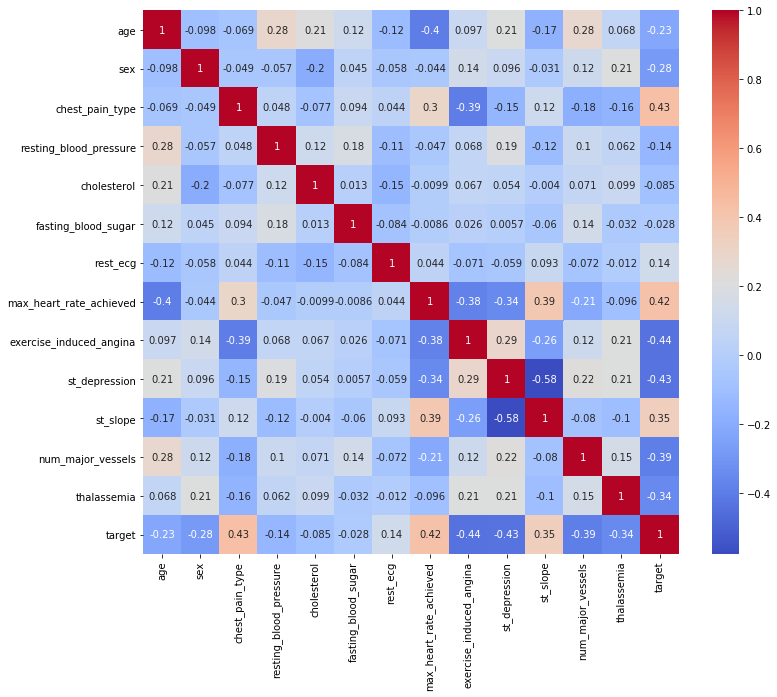

In [3]:
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.show()

It's quite evident from the above heat map that cp, thalach, slope, oldpeak and exang are the most influential variables that influece the outcome. But just to be sure let's check them out

In [4]:
#Correlation with output variable
cor_target = abs(cor["target"])#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

chest_pain_type            0.433798
max_heart_rate_achieved    0.421741
exercise_induced_angina    0.436757
st_depression              0.430696
target                     1.000000
Name: target, dtype: float64

Now split the dataset into Training and Testing sets and apply Standard Scalar.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=None)

Now, add all the models into a list and then use a for loop to iterate over the models and get their respective accuracy scores also let's check the impact of standarization on the accuracy of the models

In [6]:
classifiers = [LogisticRegression, MLPClassifier, KNeighborsClassifier, tree.DecisionTreeClassifier, RandomForestClassifier, SVC]
for model in classifiers:
    classifier = model()
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test) 
    print("{} model accuracy: {}".format(model, np.amax(cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10), axis = 0)))

<class 'sklearn.linear_model._logistic.LogisticRegression'> model accuracy: 0.9047619047619048
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'> model accuracy: 0.9047619047619048
<class 'sklearn.neighbors._classification.KNeighborsClassifier'> model accuracy: 0.7142857142857143
<class 'sklearn.tree._classes.DecisionTreeClassifier'> model accuracy: 0.8095238095238095
<class 'sklearn.ensemble._forest.RandomForestClassifier'> model accuracy: 0.95
<class 'sklearn.svm._classes.SVC'> model accuracy: 0.7142857142857143


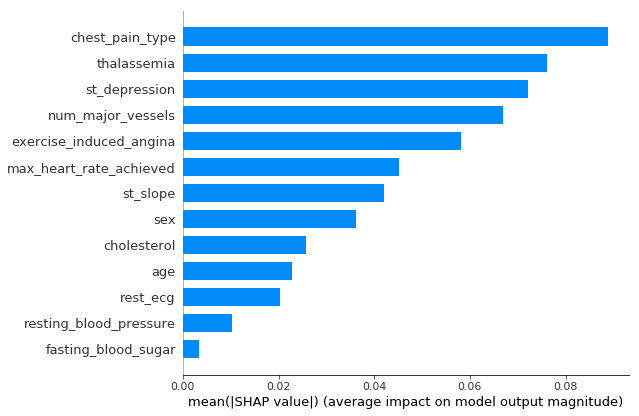

In [7]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

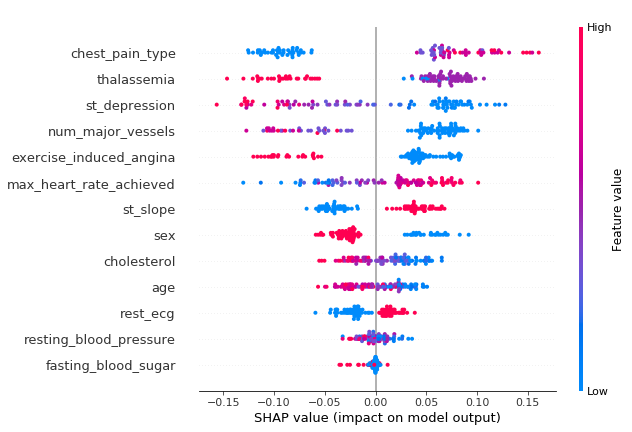

In [8]:
shap.summary_plot(shap_values[1], X_test)

In [9]:
shap.initjs()
shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])

With 85% accuracy which good so far, Random Forest Classifier and Logistic Classifier seems to be best in comparision to other classifiers. Now let's plot and see the target with train and test sets of the most influential attributes that we figured out above.

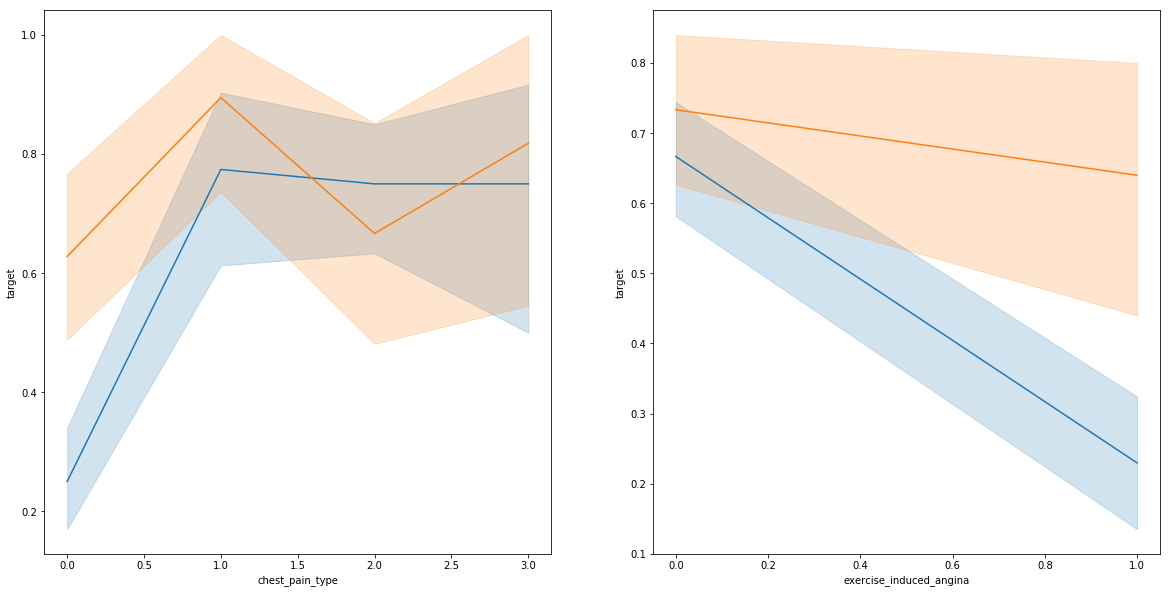

In [10]:
f, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(X_train['chest_pain_type'],y_train,ax=axes[0])
sns.lineplot(X_test['chest_pain_type'],y_pred,ax=axes[0])
sns.lineplot(X_train['exercise_induced_angina'],y_train,ax=axes[1])
sns.lineplot(X_test['exercise_induced_angina'],y_pred,ax=axes[1])